## Time Series Forecasting For Electricity Consumption Data

### Preprocess Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz, plot_tree

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



In [2]:
# load data
file_path = 'Electricity Consumption 2015-2020.csv'
df = pd.read_csv(file_path)

# preprocess data

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# Remove dots (thousand separators) and replace commas with dots (decimal points)
df['Consumption Amount (MWh)'] = df['Consumption Amount (MWh)'].str.replace('.', '', regex=False)
df['Consumption Amount (MWh)'] = df['Consumption Amount (MWh)'].str.replace(',', '.', regex=False)

# Convert the column to a numeric type (float)
df['Consumption Amount (MWh)'] = df['Consumption Amount (MWh)'].astype(float)
# Merge Date and Time column as one Datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'])
df.drop(columns=['Date', 'Time'], inplace=True)
df.set_index('DateTime', inplace=True)

# Remove duplicate rows based on the index
df = df[~df.index.duplicated(keep='first')]

# fill missing hourly vals
df = df.resample('h').ffill()

print(df.isna().sum())

df

Consumption Amount (MWh)    0
dtype: int64


Consumption Amount (MWh)
DateTime                                     
2015-12-31 00:00:00                  29590.88
2015-12-31 01:00:00                  27785.43
2015-12-31 02:00:00                  26516.53
2015-12-31 03:00:00                  26091.62
2015-12-31 04:00:00                  25871.54
...                                       ...
2020-06-30 19:00:00                  37594.26
2020-06-30 20:00:00                  37844.68
2020-06-30 21:00:00                  38029.17
2020-06-30 22:00:00                  37113.48
2020-06-30 23:00:00                  35686.77

[39456 rows x 1 columns]

In [3]:
# Find all rows where Consumption Amount is zero
zero_consumption = df[df['Consumption Amount (MWh)'] == 0]

# Display the rows with zero consumption
print(zero_consumption)

# Count the number of zero values
zero_count = zero_consumption.shape[0]
print(f"Number of zero consumption records: {zero_count}")

                     Consumption Amount (MWh)
DateTime                                     
2016-03-27 02:00:00                       0.0
2016-03-27 03:00:00                       0.0
Number of zero consumption records: 2


In [4]:
#removing row with zero consumption value
df = df[df['Consumption Amount (MWh)'] != 0]

### Plotting and PACF

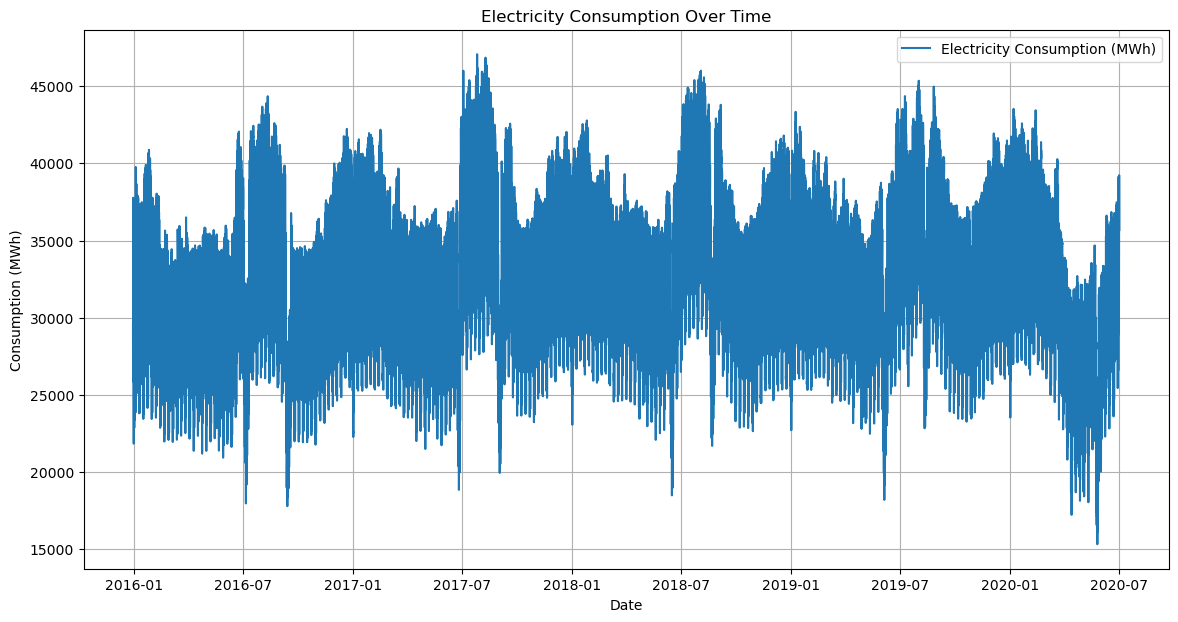

In [5]:
# Time series plot of electricity consumption
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption Amount (MWh)'], label='Electricity Consumption (MWh)')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (MWh)')
plt.legend()
plt.grid(True)
plt.show()

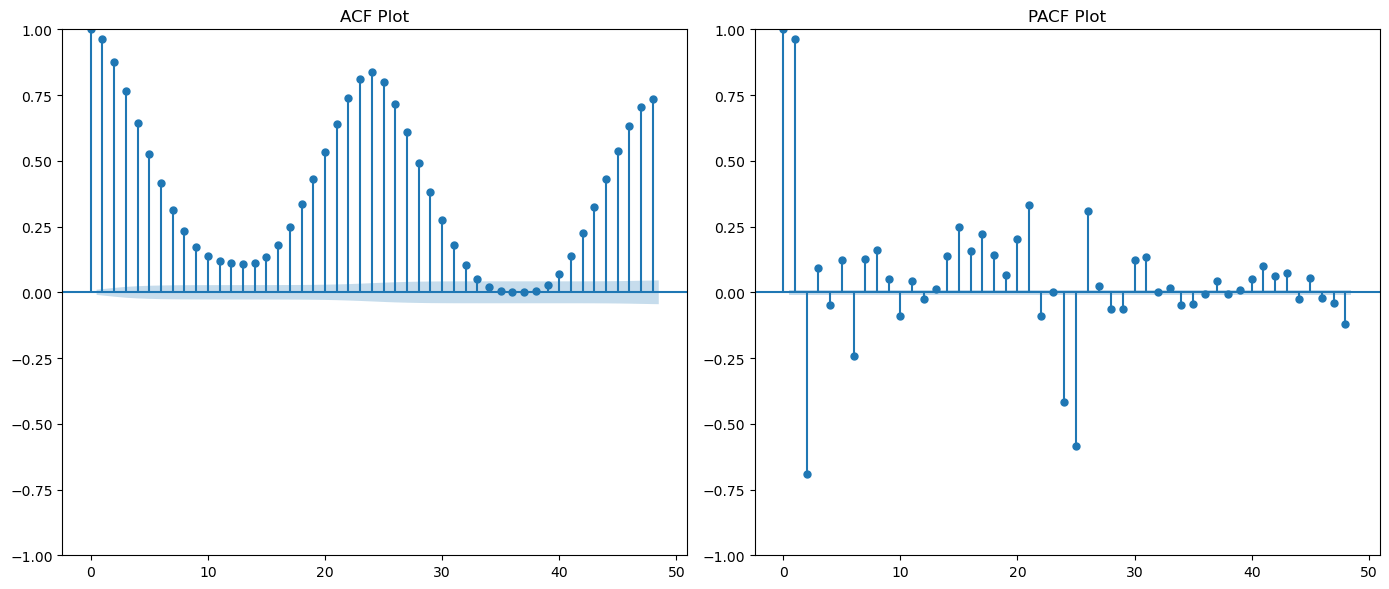

In [27]:
series = df['Consumption Amount (MWh)']

# Plot ACF
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(series, lags=48, ax=plt.gca())
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(series, lags=48, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

### Prepare Dataframe for Model Training

In [7]:
number_of_lags = 26

df_processed = df.copy()
col_name = 'Usage'
df_processed.rename(columns={'Consumption Amount (MWh)':f'{col_name}'}, inplace=True)

def new_func(number_of_lags, df_processed):
    for lag in range(1, number_of_lags+1):
        df_processed[f'{col_name}_t-{lag}'] = df_processed[f'{col_name}'].shift(lag)

new_func(number_of_lags, df_processed)

# Droping rows with NaN values (due to lagging)
df_processed.dropna(axis=0, inplace=True)

df_processed


Usage  Usage_t-1  Usage_t-2  Usage_t-3  Usage_t-4  \
DateTime                                                                    
2016-01-01 02:00:00  23532.61   24991.82   26277.24   27705.82   28606.05   
2016-01-01 03:00:00  22464.78   23532.61   24991.82   26277.24   27705.82   
2016-01-01 04:00:00  22002.91   22464.78   23532.61   24991.82   26277.24   
2016-01-01 05:00:00  21957.08   22002.91   22464.78   23532.61   24991.82   
2016-01-01 06:00:00  22203.54   21957.08   22002.91   22464.78   23532.61   
...                       ...        ...        ...        ...        ...   
2020-06-30 19:00:00  37594.26   38252.07   39031.29   39228.24   38952.02   
2020-06-30 20:00:00  37844.68   37594.26   38252.07   39031.29   39228.24   
2020-06-30 21:00:00  38029.17   37844.68   37594.26   38252.07   39031.29   
2020-06-30 22:00:00  37113.48   38029.17   37844.68   37594.26   38252.07   
2020-06-30 23:00:00  35686.77   37113.48   38029.17   37844.68   37594.26   

                     Usage_t-5  Usage_t-6  Usage_t-7  Usage_t-8  Usage_t-9  \
DateTime                                                                     
2016-01-01 02:00:00   28960.53   30138.36   32030.51   33700.44   35753.29   
2016-01-01 03:00:00   28606.05   28960.53   30138.36   32030.51   33700.44   
2016-01-01 04:00:00   27705.82   28606.05   28960.53   30138.36   32030.51   
2016-01-01 05:00:00   26277.24   27705.82   28606.05   28960.53   30138.36   
2016-01-01 06:00:00   24991.82   26277.24   27705.82   28606.05   28960.53   
...                        ...        ...        ...        ...        ...   
2020-06-30 19:00:00   38767.98   37488.38   36546.24   37579.14   36985.66   
2020-06-30 20:00:00   38952.02   38767.98   37488.38   36546.24   37579.14   
2020-06-30 21:00:00   39228.24   38952.02   38767.98   37488.38   36546.24   
2020-06-30 22:00:00   39031.29   39228.24   38952.02   38767.98   37488.38   
2020-06-30 23:00:00   38252.07   39031.29   39228.24   38952.02   38767.98   

                     ...  Usage_t-17  Usage_t-18  Usage_t-19  Usage_t-20  \
DateTime             ...                                                   
2016-01-01 02:00:00  ...    35759.14    32321.87    28103.02    26889.99   
2016-01-01 03:00:00  ...    37296.87    35759.14    32321.87    28103.02   
2016-01-01 04:00:00  ...    37768.72    37296.87    35759.14    32321.87   
2016-01-01 05:00:00  ...    36450.06    37768.72    37296.87    35759.14   
2016-01-01 06:00:00  ...    36764.22    36450.06    37768.72    37296.87   
...                  ...         ...         ...         ...         ...   
2020-06-30 19:00:00  ...    31610.04    32325.20    34453.46    36350.28   
2020-06-30 20:00:00  ...    30571.58    31610.04    32325.20    34453.46   
2020-06-30 21:00:00  ...    29949.92    30571.58    31610.04    32325.20   
2020-06-30 22:00:00  ...    28998.57    29949.92    30571.58    31610.04   
2020-06-30 23:00:00  ...    28924.08    28998.57    29949.92    30571.58   

                     Usage_t-21  Usage_t-22  Usage_t-23  Usage_t-24  \
DateTime                                                              
2016-01-01 02:00:00    26053.84    25871.54    26091.62    26516.53   
2016-01-01 03:00:00    26889.99    26053.84    25871.54    26091.62   
2016-01-01 04:00:00    28103.02    26889.99    26053.84    25871.54   
2016-01-01 05:00:00    32321.87    28103.02    26889.99    26053.84   
2016-01-01 06:00:00    35759.14    32321.87    28103.02    26889.99   
...                         ...         ...         ...         ...   
2020-06-30 19:00:00    37952.99    38873.98    38532.71    37734.14   
2020-06-30 20:00:00    36350.28    37952.99    38873.98    38532.71   
2020-06-30 21:00:00    34453.46    36350.28    37952.99    38873.98   
2020-06-30 22:00:00    32325.20    34453.46    36350.28    37952.99   
2020-06-30 23:00:00    31610.04    32325.20    34453.46    36350.28   

                     Usage_t-25  Usage_t-26  
DateTime                                     
20

### Persistence / Naive model

In [23]:
train_size = 0.7  # 70% for training
validation_size = 0.15  # 15% for validation, 15% for testing

# split into train + (validation + test)
df_train_naive, df_temp_naive = train_test_split(df_processed, train_size=train_size, shuffle=False)

#split the temp set into validation and test sets, 50% for val and 50% for test from the remaining 30%
df_val_naive, df_test_naive = train_test_split(df_temp_naive, test_size=0.5, shuffle=False)  

# Create lagged feature 'Usage_t-1' for each of train, validation, and test datasets
df_train_naive['Usage_t-1'] = df_train_naive['Usage'].shift(1)
df_val_naive['Usage_t-1'] = df_val_naive['Usage'].shift(1)
df_test_naive['Usage_t-1'] = df_test_naive['Usage'].shift(1)

# Drop the NaN values caused by shifting
df_train_naive.dropna(inplace=True)
df_val_naive.dropna(inplace=True)
df_test_naive.dropna(inplace=True)

# metrics for the naive model

# For Train Set
train_rmse_naive = root_mean_squared_error(df_train_naive['Usage'], df_train_naive['Usage_t-1'])
train_mae_naive = mean_absolute_error(df_train_naive['Usage'], df_train_naive['Usage_t-1'])
train_mape_naive = mean_absolute_percentage_error(df_train_naive['Usage'], df_train_naive['Usage_t-1'])

# For Validation Set
val_rmse_naive = root_mean_squared_error(df_val_naive['Usage'], df_val_naive['Usage_t-1'])
val_mae_naive = mean_absolute_error(df_val_naive['Usage'], df_val_naive['Usage_t-1'])
val_mape_naive = mean_absolute_percentage_error(df_val_naive['Usage'], df_val_naive['Usage_t-1'])

# For Test Set
test_rmse_naive = root_mean_squared_error(df_test_naive['Usage'], df_test_naive['Usage_t-1'])
test_mae_naive = mean_absolute_error(df_test_naive['Usage'], df_test_naive['Usage_t-1'])
test_mape_naive = mean_absolute_percentage_error(df_test_naive['Usage'], df_test_naive['Usage_t-1'])

print("Naive (Persistence) Model Performance:")
print(f'Train RMSE: {train_rmse_naive}, MAE: {train_mae_naive}, MAPE: {train_mape_naive}')
print(f'Validation RMSE: {val_rmse_naive}, MAE: {val_mae_naive}, MAPE: {val_mape_naive}')
print(f'Test RMSE: {test_rmse_naive}, MAE: {test_mae_naive}, MAPE: {test_mape_naive}')

Naive (Persistence) Model Performance:
Train RMSE: 1401.9370654767592, MAE: 1053.1553514747445, MAPE: 0.0325793255941398
Validation RMSE: 1295.4964571365842, MAE: 991.6995839675291, MAPE: 0.030328711149743302
Test RMSE: 1279.0107981957656, MAE: 991.3592813662494, MAPE: 0.03173777339273482


In [24]:
# Combine train, validation, and test sets for easier plotting
df_train_naive['Type'] = 'Train'
df_val_naive['Type'] = 'Validation'
df_test_naive['Type'] = 'Test'

df_combined_naive = pd.concat([df_train_naive, df_val_naive, df_test_naive])
# Create traces for the Persistence Model plot
fig_naive = go.Figure()

# Add true values to the plot
fig_naive.add_trace(go.Scatter(x=df_combined_naive.index, y=df_combined_naive['Usage'],
                               mode='lines',
                               name='True Consumption',
                               line=dict(color='blue')))

# Add persistence model predictions to the plot
fig_naive.add_trace(go.Scatter(x=df_combined_naive.index, y=df_combined_naive['Usage_t-1'],
                               mode='lines',
                               name='Persistence Prediction (t-1)',
                               line=dict(dash='dash', color='red')))

fig_naive.update_layout(
    title='Persistence Model Predictions vs Actual Values (Train, Validation, Test)',
    xaxis_title='DateTime',
    yaxis_title='Electricity Consumption (MWh)',
    legend=dict(x=0, y=1),
    template='plotly_white'
)

# Show the plot
fig_naive.show()



### Random Forest with Grid Search 

In [11]:
# Split data into train, validation, and test sets
train_size_rf_grid = 0.7  # 70% for training
validation_size_rf_grid = 0.15  # 15% for validation, 15% for testing

# split into train + (validation + test)
df_train_rf_grid, df_temp_rf_grid = train_test_split(df_processed, train_size=train_size_rf_grid, shuffle=False)

# Now split the temp set into validation and test sets
df_val_rf_grid, df_test_rf_grid = train_test_split(df_temp_rf_grid, test_size=0.5, shuffle=False)

# Define features (X) and target (y) for the training, validation, and test sets
X_train_rf_grid = df_train_rf_grid.drop(columns=['Usage'])
y_train_rf_grid = df_train_rf_grid['Usage']

X_val_rf_grid = df_val_rf_grid.drop(columns=['Usage'])
y_val_rf_grid = df_val_rf_grid['Usage']

X_test_rf_grid = df_test_rf_grid.drop(columns=['Usage'])
y_test_rf_grid = df_test_rf_grid['Usage']

In [12]:

# Define the Random Forest model and parameter grid
rf_grid = RandomForestRegressor(random_state=42)

param_grid_rf_grid = {
    'n_estimators': [50, 100, 150, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, 40, None]  # Maximum depth of the tree
}

# Define the scorer (MSE for minimizing error)
scorer_rf_grid = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize variables to track the best hyperparameters
best_params_rf_grid = None
best_val_score_rf_grid = float('inf')
best_model_rf_grid = None

# Manual grid search loop
for n_estimators in param_grid_rf_grid['n_estimators']:
    for max_depth in param_grid_rf_grid['max_depth']:
        # Train the Random Forest model on 70% train data
        model_rf_grid = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model_rf_grid.fit(X_train_rf_grid, y_train_rf_grid)

        # Validate the model on 15% validation data
        y_val_pred_rf_grid = model_rf_grid.predict(X_val_rf_grid)
        val_mse_rf_grid = mean_squared_error(y_val_rf_grid, y_val_pred_rf_grid)

        # Track the best hyperparameters based on validation MSE
        if val_mse_rf_grid < best_val_score_rf_grid:
            best_val_score_rf_grid = val_mse_rf_grid
            best_params_rf_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
            best_model_rf_grid = model_rf_grid

# Print the best hyperparameters
print(f"Best hyperparameters: {best_params_rf_grid}")
print(f"Best validation MSE: {best_val_score_rf_grid}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 30}
Best validation MSE: 202829.26215301262


In [13]:
# Retrain the best model on combined train + validation set (85% data)
X_train_val_rf_grid = pd.concat([X_train_rf_grid, X_val_rf_grid])
y_train_val_rf_grid = pd.concat([y_train_rf_grid, y_val_rf_grid])

best_model_rf_grid.fit(X_train_val_rf_grid, y_train_val_rf_grid)

# Evaluate the model on the holdout test set (15%)
y_test_pred_rf_grid = best_model_rf_grid.predict(X_test_rf_grid)

# Calculate test metrics
test_rmse_rf_grid = root_mean_squared_error(y_test_rf_grid, y_test_pred_rf_grid)
test_mae_rf_grid = mean_absolute_error(y_test_rf_grid, y_test_pred_rf_grid)
test_mape_rf_grid = mean_absolute_percentage_error(y_test_rf_grid, y_test_pred_rf_grid)

print(f"Test RMSE: {test_rmse_rf_grid}")
print(f"Test MAE: {test_mae_rf_grid}")
print(f"Test MAPE: {test_mape_rf_grid}")

Test RMSE: 553.2030730721581
Test MAE: 370.3896574656333
Test MAPE: 0.012686343807355584


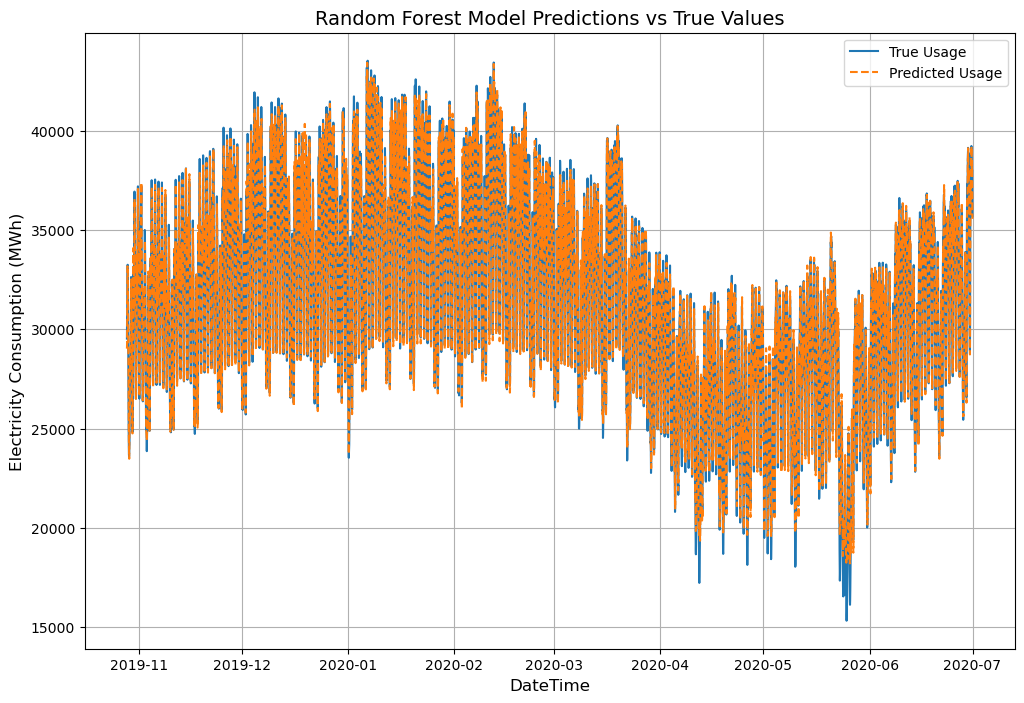

In [14]:
plt.figure(figsize=(12, 8))

# Plot true values
plt.plot(y_test_rf_grid.index, y_test_rf_grid, label='True Usage')

# Plot predicted values
plt.plot(y_test_rf_grid.index, y_test_pred_rf_grid, label='Predicted Usage' ,linestyle='--' )

plt.title('Random Forest Model Predictions vs True Values', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Electricity Consumption (MWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

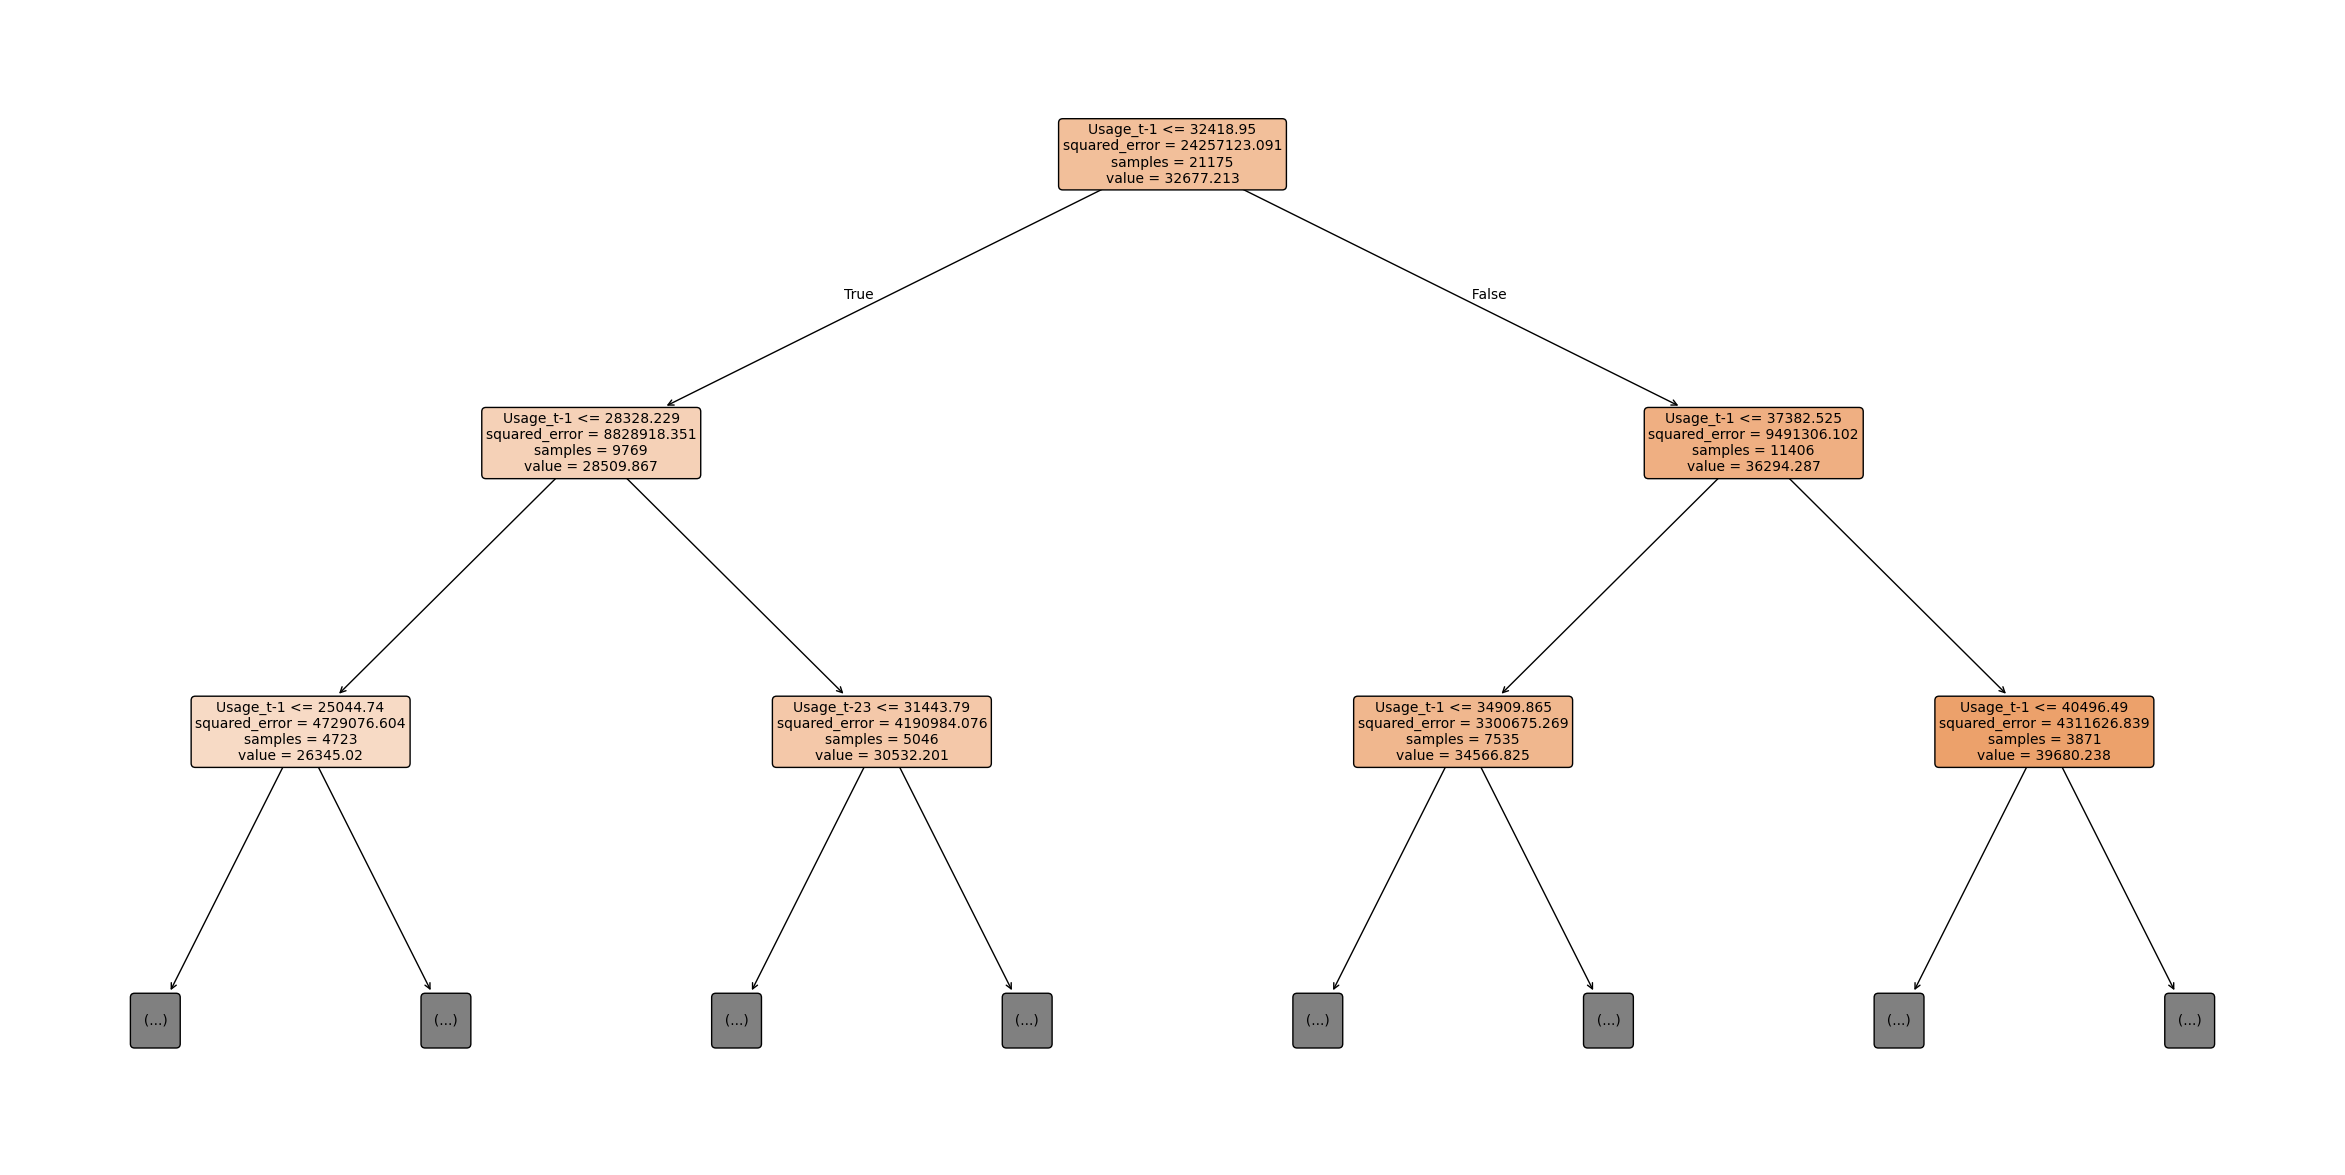

In [16]:
# Plotting a single decision tree from the Random Forest model
single_tree_rf_grid = best_model_rf_grid.estimators_[0]

plt.figure(figsize=(30, 15))  

# Plot the tree
plot_tree(single_tree_rf_grid, 
          feature_names=X_train_val_rf_grid.columns, 
          filled=True,  
          rounded=True,  
          fontsize=10,  
          max_depth=2)  

plt.show()

In [17]:
# Calculating number of samples in leaf nodes
leaf_samples_rf_grid = []

for estimator in best_model_rf_grid.estimators_:
    n_samples_per_node_rf_grid = estimator.tree_.n_node_samples
    is_leaf_rf_grid = estimator.tree_.children_left == -1
    leaf_samples_rf_grid.extend(n_samples_per_node_rf_grid[is_leaf_rf_grid])


leaf_samples_rf_grid = np.array(leaf_samples_rf_grid)

# Display the leaf node sample statistics
print(f"Total number of leaf nodes: {len(leaf_samples_rf_grid)}")
print(f"Mean number of samples per leaf node: {np.mean(leaf_samples_rf_grid)}")
print(f"Minimum number of samples in a leaf node: {np.min(leaf_samples_rf_grid)}")
print(f"Maximum number of samples in a leaf node: {np.max(leaf_samples_rf_grid)}")

Total number of leaf nodes: 6353223
Mean number of samples per leaf node: 1.000188093507815
Minimum number of samples in a leaf node: 1
Maximum number of samples in a leaf node: 14


### Long Short Term Memory Neural Network with Gridsearch

In [18]:
#  Split data into train, validation, and test sets
train_size = 0.7  # 70% for training

# split into train + (validation + test)
df_train, df_temp = train_test_split(df_processed, train_size=train_size, shuffle=False)

# split the temp set into validation and test sets
df_val, df_test = train_test_split(df_temp, test_size=0.5, shuffle=False)  # 50% for val and 50% for test from the remaining 30%

# Scaler for input scaling
scaler_lstm = MinMaxScaler()

# Fit the scaler only on the training data
scaler_lstm.fit(df_train[['Usage']])

# Scale training, validation, and test data
scaled_train_lstm = scaler_lstm.transform(df_train[['Usage']])
scaled_val_lstm = scaler_lstm.transform(df_val[['Usage']])
scaled_test_lstm = scaler_lstm.transform(df_test[['Usage']])

# Create sequences for LSTM input
def create_lstm_sequences(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:i + n_input])  # Input sequence of n_input time steps
        y.append(data[i + n_input])    # Target value (the next step)
    return np.array(X), np.array(y)

# Define the input size and prepare the sequences for LSTM
n_input_lstm = 26

X_train_lstm, y_train_lstm = create_lstm_sequences(scaled_train_lstm, n_input_lstm)
X_val_lstm, y_val_lstm = create_lstm_sequences(scaled_val_lstm, n_input_lstm)
X_test_lstm, y_test_lstm = create_lstm_sequences(scaled_test_lstm, n_input_lstm)


In [25]:
# shapes of the data to ensure correctness
print(f"Training data shape: {X_train_lstm.shape}, {y_train_lstm.shape}")
print(f"Validation data shape: {X_val_lstm.shape}, {y_val_lstm.shape}")
print(f"Test data shape: {X_test_lstm.shape}, {y_test_lstm.shape}")

Training data shape: (27573, 26, 1), (27573, 1)
Validation data shape: (5888, 26, 1), (5888, 1)
Test data shape: (5889, 26, 1), (5889, 1)


In [19]:
# Function to create the LSTM model
def create_lstm_model(n_units_1, n_units_2, dropout_rate, learning_rate, n_input=26, n_features=1):
    model_lstm = Sequential()

    # First LSTM layer
    model_lstm.add(LSTM(n_units_1, return_sequences=True, input_shape=(n_input, n_features)))
    model_lstm.add(Dropout(dropout_rate))

    # Second LSTM layer
    model_lstm.add(LSTM(n_units_2, return_sequences=False))
    model_lstm.add(Dropout(dropout_rate))

    # Dense layer
    model_lstm.add(Dense(32, activation='relu'))

    # Output layer
    model_lstm.add(Dense(1))

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model_lstm.compile(optimizer=optimizer, loss='mse')

    return model_lstm

In [21]:
# Define the hyperparameters to search
param_grid_lstm = {
    'n_units_1': [50, 100, 150],
    'n_units_2': [20, 40, 60],
    'dropout_rate': [0.1, 0.3],
    'learning_rate': [0.001],
    'epochs': [200],
    'batch_size': [32, 64]
}

# grid search loop 
best_rmse = float('inf')
best_params = {}
best_model = None
epochs_ran = None  # Variable to track how many epochs the model ran

for n_units_1 in param_grid_lstm['n_units_1']:
    for n_units_2 in param_grid_lstm['n_units_2']:
        for dropout_rate in param_grid_lstm['dropout_rate']: 
            for learning_rate in param_grid_lstm['learning_rate']:  
                for epochs in param_grid_lstm['epochs']:
                    for batch_size in param_grid_lstm['batch_size']:
                        # Create and train the model with the current set of hyperparameters
                        print(f"Training with params: units_1={n_units_1}, units_2={n_units_2}, "
                              f"dropout={dropout_rate}, lr={learning_rate}, epochs={epochs}, batch_size={batch_size}")
                        
                        model = create_lstm_model(n_units_1, n_units_2, dropout_rate, learning_rate)
                        
                        # Early stopping to monitor validation loss and prevent overfitting
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                        # Train the model on training data and validate on validation data
                        history = model.fit(
                            X_train_lstm, y_train_lstm,
                            validation_data=(X_val_lstm, y_val_lstm),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=[early_stopping]
                        )

                        # Capture the number of epochs run
                        actual_epochs_ran = len(history.history['loss'])

                        # Evaluate the model on validation data
                        val_predictions = model.predict(X_val_lstm)
                        val_predictions = np.array(val_predictions).reshape(-1, 1)
                        val_predictions_inv = scaler_lstm.inverse_transform(val_predictions)
                        y_val_inv = scaler_lstm.inverse_transform(y_val_lstm.reshape(-1, 1))

                        rmse = root_mean_squared_error(y_val_inv, val_predictions_inv)

                        # Track the best model based on validation performance
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_params = {
                                'n_units_1': n_units_1,
                                'n_units_2': n_units_2,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'epochs': actual_epochs_ran,  # Store the number of epochs ran
                                'batch_size': batch_size
                            }
                            best_model = model
                            epochs_ran = actual_epochs_ran  # Keep track of how many epochs ran

# Output the best hyperparameters and RMSE on validation data
print(f"Best Validation RMSE: {best_rmse}")
print(f"Best hyperparameters: {best_params}")
print(f"Best model ran for {epochs_ran} epochs before early stopping.")


Training with params: units_1=50, units_2=20, dropout=0.1, lr=0.001, epochs=200, batch_size=32
Epoch 1/200


d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0305 - val_loss: 0.0044
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 9.1336e-04 - val_loss: 0.0010
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 8.3303e-04 - val_loss: 0.0023
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 7.5484e-04 - val_loss: 8.4321e-04
Epoch 12/200
86

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0607 - val_loss: 0.0060
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0012 - val_loss: 9.5922e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/200
431/431 ━━━━━━━━━━━━━━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0304 - val_loss: 0.0102
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0015 - val_loss: 0.0081
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0013 - val_loss: 0.0066
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0011 - val_loss: 0.0086
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0010 - val_loss: 0.0086
Epoch 12/200
862/862 ━━━━━━━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0426 - val_loss: 0.0117
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 12/200
431/431 ━━━━━━━━━━━━━━━━━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0209 - val_loss: 0.0029
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.9583e-04 - val_loss: 0.0011
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.5253e-04 - val_loss: 0.0010
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.7854e-04 - val_loss: 6.9759e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 8.5242e-04 - val_loss: 9.0293e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 7.8700e-04 - val_loss: 0.0010
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.4941e-04 - val_loss: 7.8685

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0327 - val_loss: 0.0055
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0014 - val_loss: 8.4571e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0011 - val_loss: 8.8361e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0011 - val_loss: 7.8750e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0010 - val_loss: 8.2806e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9.5550e-04 - val_loss: 0.0010
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 9.4437e-04 - val_loss: 7.4100e-04
Epoch 12/200


d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0218 - val_loss: 0.0033
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0012 - val_loss: 9.4373e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0011 - val_loss: 9.8718e-04
Epoch 12/200
862/862 ━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0441 - val_loss: 0.0051
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0018 - val_loss: 9.6978e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0016 - val_loss: 9.9759e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0015 - val_loss: 9.5085e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0014 - val_loss: 8.9780e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 12/200
431/431 ━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0224 - val_loss: 0.0024
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0012 - val_loss: 9.1926e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9.7313e-04 - val_loss: 7.1718e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.8653e-04 - val_loss: 6.8106e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.3847e-04 - val_loss: 7.4116e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 7.6008e-04 - val_loss: 7.2163e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 7.2256e-04 - val_loss: 7.5591e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 6.6264e-04 - val_loss: 5.6278e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 6.475

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0316 - val_loss: 0.0037
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0012 - val_loss: 7.5241e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0011 - val_loss: 7.3758e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 9.9907e-04 - val_loss: 7.4199e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 9.6662e-04 - val_loss: 7.9566e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 9.1501e-04 - val_loss: 6.6257e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 8.4033e-04 - val_loss: 7.9796e-

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0284 - val_loss: 0.0039
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0016 - val_loss: 9.6108e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0014 - val_loss: 8.1810e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0013 - val_loss: 8.9137e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0012 - val_loss: 8.0287e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0012 - val_loss: 8.2643e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0011 - val_loss: 6.8433e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0010 - val_loss: 7.3963e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0010 - val_loss: 7.3022e-04

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.0387 - val_loss: 0.0057
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0017 - val_loss: 9.8062e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0016 - val_loss: 9.4458e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0014 - val_loss: 8.7954e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0014 - val_loss: 8.8283e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0013 - val_loss: 6.9555e-04
Epoch 12/200
431

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0260 - val_loss: 0.0039
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0011 - val_loss: 9.3150e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0010 - val_loss: 8.1973e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 9.2070e-04 - val_loss: 0.0010
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 8.2842e-04 - val_loss: 7.8008e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 7.8903e-04 - val_loss: 7.2620e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 6.9315e-04 - val_loss: 7.3064e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 6.3773e-04 - val_loss

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0316 - val_loss: 0.0066
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 9.7435e-04 - val_loss: 0.0012
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 9.3215e-04 - val_loss: 0.0016
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 9.0006e-04 - val_loss: 0.0020
Epoch 12/200
431/431 

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0340 - val_loss: 0.0072
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0010 - val_loss: 0.0051
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 9.7309e-04 - val_loss: 0.0056
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.6409e-04 - val_loss: 0.0055
Epoch 12/200
862/862 ━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0361 - val_loss: 0.0089
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 12/200
431/431 ━━━━━━━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0198 - val_loss: 0.0025
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0011 - val_loss: 7.8702e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 9.9968e-04 - val_loss: 7.2773e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 9.0043e-04 - val_loss: 7.1209e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 8.5596e-04 - val_loss: 7.1210e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 8.0723e-04 - val_loss: 6.3202e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 7.7904e-04 - val_loss: 5.8008e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 7.2674e-04 - val_loss: 5.8407e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 6.782

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.0284 - val_loss: 0.0038
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0013 - val_loss: 9.9410e-04
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 9.4246e-04 - val_loss: 0.0011
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 9.0362e-04 - val_loss: 0.0014
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 8.3838e-04 - val_loss: 0.0012
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 8.2401e-04 - val_loss: 8.7206e-04
Epoch 1

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0210 - val_loss: 0.0035
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 9.7793e-04 - val_loss: 0.0017
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 8.9966e-04 - val_loss: 0.0018
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 8.5961e-04 - val_loss: 0.0027
Epoch 12/200
862/86

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0337 - val_loss: 0.0045
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0015 - val_loss: 8.7785e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0013 - val_loss: 8.3782e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0012 - val_loss: 8.0445e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/200
431/431 

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0197 - val_loss: 0.0023
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.0015 - val_loss: 8.1607e-04
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0011 - val_loss: 7.5748e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 9.4801e-04 - val_loss: 7.2357e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 8.7917e-04 - val_loss: 6.4822e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 7.6817e-04 - val_loss: 5.7489e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 7.2006e-04 - val_loss: 6.2921e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 6.8754e-04 - val_loss: 5.1751e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 6.3180e-04 - val_loss: 5.2434e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 5

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0323 - val_loss: 0.0046
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0013 - val_loss: 9.6163e-04
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0012 - val_loss: 9.1022e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 9.0153e-04 - val_loss: 8.7368e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 8.5575e-04 - val_loss: 8.1280e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 7.8786e-04 - val_loss: 8.8446e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 7.5587e-04 - val_loss: 0.

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0191 - val_loss: 0.0037
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.0018 - val_loss: 9.1741e-04
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0015 - val_loss: 8.5172e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0013 - val_loss: 7.6483e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0012 - val_loss: 7.2748e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0011 - val_loss: 7.0525e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0010 - val_loss: 6.9003e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 9.7333e-04 - val_loss: 7.2882e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 9.3018e-04 - val_loss: 7.8238e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 8.9468e-04 - val_

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.0292 - val_loss: 0.0049
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.0014 - val_loss: 8.4499e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0013 - val_loss: 8.7700e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 0.0012 - val_loss: 7.5477e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0012 - val_loss: 8.8968e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0011 - val_loss: 7.3857e-04
Epoch 12/20

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0248 - val_loss: 0.0034
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0010 - val_loss: 6.2182e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 9.1652e-04 - val_loss: 0.0010
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 8.2472e-04 - val_loss: 9.7306e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 7.5914e-04 - val_loss: 9.7401e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 6.9136e-04 - val_loss: 0.0010
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 5.8849e-04 - val_loss: 6.9968e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 5.6764e-04 - val_loss

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.0316 - val_loss: 0.0074
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 9.5720e-04 - val_loss: 0.0016
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 8.6276e-04 - val_loss: 0.0015
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 7.6872e-04 - val_loss: 8.6773e-04
Epoch 12/200
43

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0249 - val_loss: 0.0041
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 9.5403e-04 - val_loss: 0.0041
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 8.7436e-04 - val_loss: 0.0030
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.1669e-04 - val_loss: 0.0034
Epoch 12/200
862/86

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0347 - val_loss: 0.0120
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0022 - val_loss: 0.0073
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 12/200
431/431 ━━━━━━━━━━

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.0209 - val_loss: 0.0024
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0015 - val_loss: 9.5416e-04
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0012 - val_loss: 8.0663e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0010 - val_loss: 8.5082e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 9.3352e-04 - val_loss: 6.7205e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 8.6259e-04 - val_loss: 7.6238e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.9869e-04 - val_loss: 7.0214e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 7.4451e-04 - val_loss: 6.4098e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 6.7324e-04 - val_loss: 6.4158e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 6.493

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.0274 - val_loss: 0.0039
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0016 - val_loss: 9.5360e-04
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 9.9097e-04 - val_loss: 0.0017
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 9.4131e-04 - val_loss: 0.0011
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 8.7236e-04 - val_loss: 0.0011
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 8.0748e-04 - val_loss: 8.6677e-04
Epoch 1

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0262 - val_loss: 0.0033
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0013 - val_loss: 8.3851e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0012 - val_loss: 8.4454e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0011 - val_loss: 7.0915e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0011 - val_loss: 8.7340e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 9.5513e-04 - val_loss: 6.9586e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 8.7452e-04 - val_loss: 8.9042e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 8.2759e-04 - val_loss: 9.

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0288 - val_loss: 0.0043
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0017 - val_loss: 8.5318e-04
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.0014 - val_loss: 7.9513e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0013 - val_loss: 7.7226e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 0.0012 - val_loss: 7.4122e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0011 - val_loss: 8.0064e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/20

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0203 - val_loss: 0.0018
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.0020 - val_loss: 9.0889e-04
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0013 - val_loss: 9.7931e-04
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0011 - val_loss: 8.2432e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 9.1975e-04 - val_loss: 8.7609e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 8.5690e-04 - val_loss: 7.2656e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 8.3326e-04 - val_loss: 7.2424e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 7.6252e-04 - val_loss: 6.8530e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 7.1848e-04 - val_loss: 7.1922e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 6.6996e-04 - val_loss: 5.4401e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - los

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0227 - val_loss: 0.0033
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0014 - val_loss: 9.1339e-04
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 0.0012 - val_loss: 9.3969e-04
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0010 - val_loss: 7.8721e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 9.4304e-04 - val_loss: 0.0010
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 8.7310e-04 - val_loss: 0.0011
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 8.2255e-04 - val_loss: 8.3563e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 8.0934e-04 - val_loss: 0.0014
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 7.1223e-04 - val_loss: 0.

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



862/862 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0227 - val_loss: 0.0027
Epoch 2/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 3/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0018 - val_loss: 9.6036e-04
Epoch 4/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0014 - val_loss: 8.4147e-04
Epoch 5/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.0013 - val_loss: 8.3276e-04
Epoch 6/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0012 - val_loss: 6.9097e-04
Epoch 7/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0011 - val_loss: 7.9593e-04
Epoch 8/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - loss: 0.0010 - val_loss: 6.7608e-04
Epoch 9/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 9.2640e-04 - val_loss: 5.2440e-04
Epoch 10/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 8.7319e-04 - val_loss: 7.6785e-04
Epoch 11/200
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 8.2958e-04 - val_

d:\conda\envs\ML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



431/431 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - loss: 0.0274 - val_loss: 0.0047
Epoch 2/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 3/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 4/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - loss: 0.0016 - val_loss: 9.8757e-04
Epoch 6/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0014 - val_loss: 8.8782e-04
Epoch 7/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 0.0013 - val_loss: 9.6818e-04
Epoch 8/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - loss: 0.0012 - val_loss: 8.2005e-04
Epoch 9/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0012 - val_loss: 7.3314e-04
Epoch 10/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 0.0012 - val_loss: 9.1393e-04
Epoch 11/200
431/431 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1

185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Test RMSE: 470.1144641906202
Test MAE: 336.9626737747283
Test MAPE: 0.011357986390300515


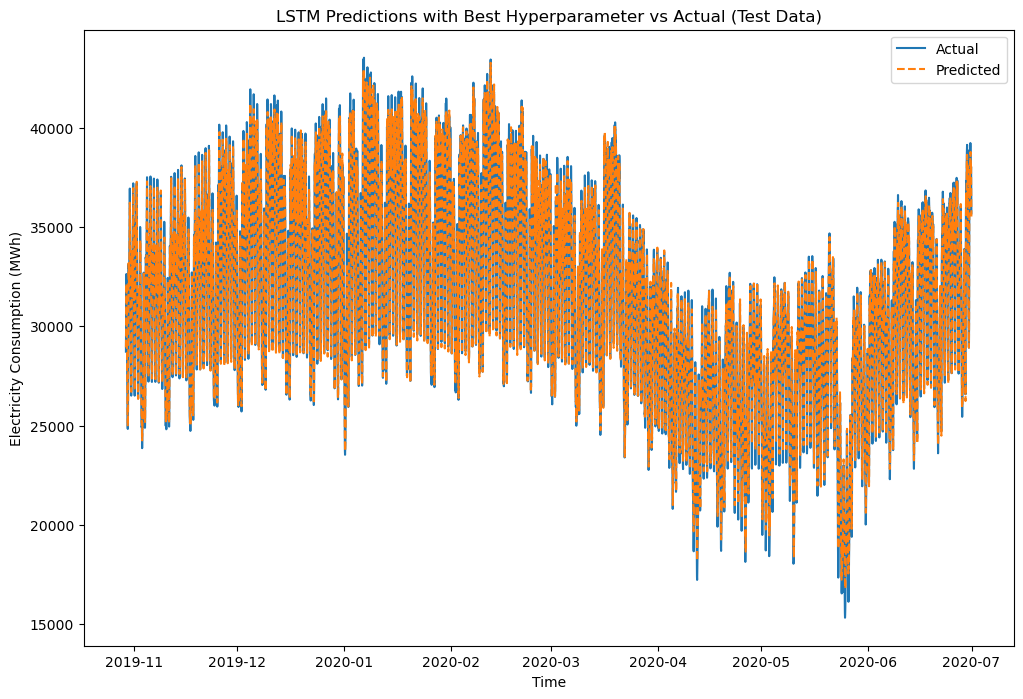

In [26]:
# Evaluate the best model on the holdout test data
best_predictions = best_model.predict(X_test_lstm)
best_predictions = np.array(best_predictions).reshape(-1, 1)

# Inverse transform the predictions and true values
best_predictions_inv = scaler_lstm.inverse_transform(best_predictions)
y_test_inv_best = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate evaluation metrics on test data
best_rmse_test = root_mean_squared_error(y_test_inv_best, best_predictions_inv)
best_mae_test = mean_absolute_error(y_test_inv_best, best_predictions_inv)
best_mape_test = mean_absolute_percentage_error(y_test_inv_best, best_predictions_inv)

# Print the final performance on the test set
print(f"Test RMSE: {best_rmse_test}")
print(f"Test MAE: {best_mae_test}")
print(f"Test MAPE: {best_mape_test}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 8))
plt.plot(df_test.index[n_input_lstm:], y_test_inv_best, label='Actual')
plt.plot(df_test.index[n_input_lstm:], best_predictions_inv, label='Predicted', linestyle='--')
plt.title('LSTM Predictions with Best Hyperparameter vs Actual (Test Data)')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (MWh)')
plt.legend()
plt.show()